# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [99]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
import nltk
import scipy.stats
from collections import defaultdict

In [5]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [7]:
X, y = read_dataset("./hw6_data/spam")

<ipython-input-5-c1364a5e16ee>:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(x, dtype=np.str), np.array(y, dtype=np.str)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [104]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        classes, repeat_number = np.unique(y, return_counts=True)
        self.classes = classes
        self.repeat_number = repeat_number
        
        self.P_y = repeat_number / len(y)
        
        A = []
        for post_exp in self.classes:
            A.append(X[y == post_exp])
        
        
        self.freq_des_mots = []
        for i in A:
            self.freq_des_mots.append((i.sum(axis=0) + self.alpha) / (i.sum() + self.alpha * i.shape[1]))
            
        
    def predict(self, X):
        answer = []
        for i in np.argmax(self.log_proba(X), axis=1):
            answer.append(self.classes[i])
        return answer
    
    def log_proba(self, X):
        n = len(self.classes)
        answer = np.zeros((len(X), n))
        
        for i in range(len(X)):
            for j in range(n):
                answer[i, j] = scipy.stats.multinomial(X[i].sum(), self.freq_des_mots[j]).logpmf(X[i]) + np.log(self.P_y[j])
        return answer

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [135]:
import re
import string
from itertools import chain
from collections import Counter

class BoW:
    def __init__(self, X, voc_limit=1000):
        dict_pair = Counter(chain(*[nltk.word_tokenize(text_preproc(x)) for x in X])).most_common(voc_limit)
        self.dict = {word[0]: idx for word, idx in zip(dict_pair, range(voc_limit))}
        
    def transform(self, X):
        answer = []
        n_dict = len(self.dict)
        for i in range(len(X)):
            cur_answer = np.zeros((n_dict,))
            phrase = Counter(X[i].split())
            for mot, c in phrase.items():
                if mot in self.dict:
                    cur_answer[self.dict[mot]] += c
            answer.append(cur_answer)
            
        return np.array(answer)

In [136]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [137]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9799196787148594, 'spam': 0.8333333333333334},
 {'ham': 0.9799196787148594, 'spam': 0.8333333333333334},
 0.96415770609319)

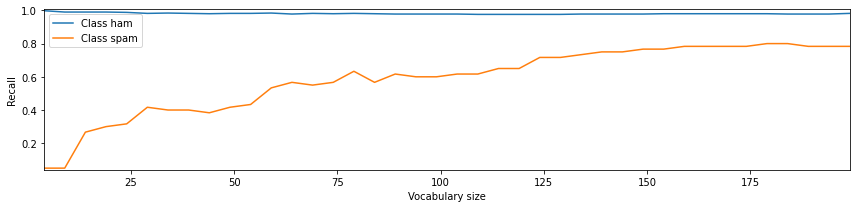

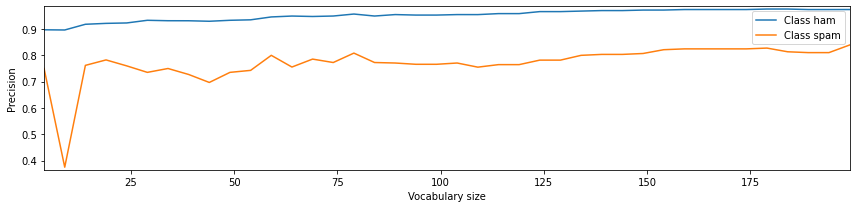

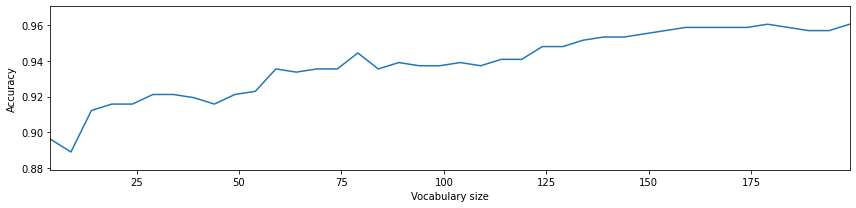

In [138]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [158]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        array_st = SnowballStemmer('english')
        dict_pair = Counter(array_st.stem(i) for i in chain(*[nltk.word_tokenize(x) for x in X])).most_common(voc_limit)
        self.dict = {word[0]: idx for word, idx in zip(dict_pair, range(voc_limit))}
        
    def transform(self, X):
        array_st = SnowballStemmer('english')
        answer = []
        n_dict = len(self.dict)
        for i in range(len(X)):
            cur_answer = np.zeros((n_dict,))
            phrase = Counter(array_st.stem(x) for x in X[i].split())
            for mot, c in phrase.items():
                if mot in self.dict:
                    cur_answer[self.dict[mot]] += c
            answer.append(cur_answer)
            
        return np.array(answer)
 

In [159]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [155]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9859154929577465, 'spam': 0.8688524590163934},
 {'ham': 0.9839357429718876, 'spam': 0.8833333333333333},
 0.9731182795698925)

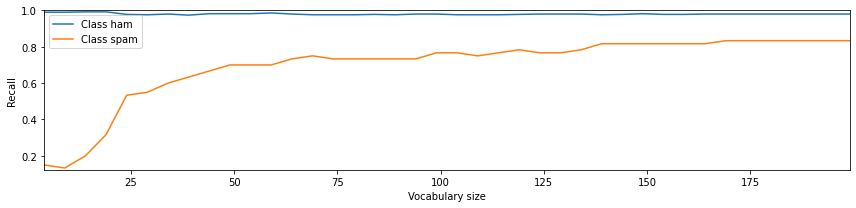

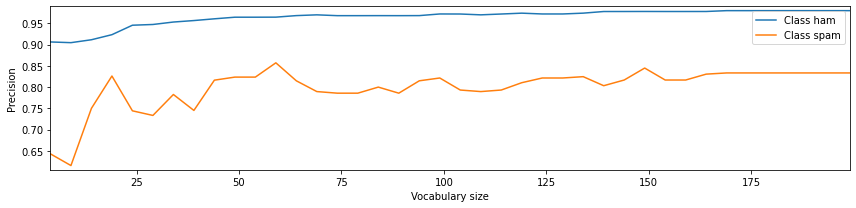

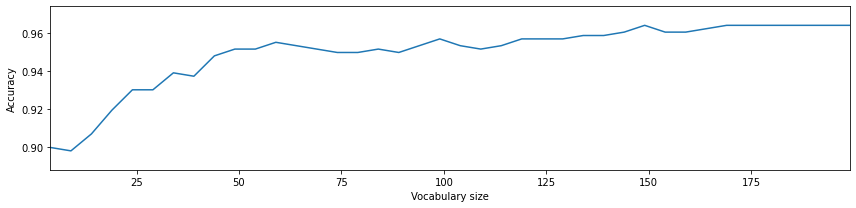

In [149]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)